# Advanced options for implicit time integration: linear solvers & advection-diffusion

_Highlights_
- "plug and play" of a variety of linear solvers for adaptive, high-order implicit Runge-Kutta scheme to solve an unsteady advection-diffusion equation
- the scalability of different methods is shown as we increase the number of nodes in the spatial discretization

## Introduction

This notebook demonstrates advanced use of Spitfire's implicit time integration methods for solving a partial differential equation (PDE) describing transport of a quantity by advection and diffusion. The unsteady advection-diffusion equation for a spatially one-dimensional field $q(t,x)$ is

$$ \frac{\partial q}{\partial t} + \frac{\partial q}{\partial x} = \frac{1}{\mathrm{Pe}}\frac{\partial^2 q}{\partial x^2}$$

where $\mathrm{Pe}$ is the [Peclet number](https://en.wikipedia.org/wiki/Péclet_number).
We consider this PDE on a periodic domain, which could be thought of as a ring where anything transporting out of the right/left edge flows immediately into the left/right edge.
Unsteady advection-diffusion on a periodic domain is a common problem for studying numerical methods for discretizing PDEs spatially and temporally, as certain initial conditions for $q(0,x)$ admit anaylytical solutions that may be easily evaluated.

We're going to discretize the PDE in space with elementary [nodal finite differences](https://en.wikipedia.org/wiki/Finite_difference_method), wherein second-order centered differences are used to approximate the first and second derivatives (in space) in the PDE.
As for the time derivative, we're going to employ the [method of lines](http://www.scholarpedia.org/article/Method_of_lines), which is one way of saying that we compile the spatially-discretized scheme into a system of ordinary differential equations (ODEs) with one equation per node in space.
We may then apply any of Spitfire's time-stepping schemes to the system of ODEs.


## Linear Solvers
The details of our spatial discretization are widely available on the web and so we skip over them. The purpose of this notebook is to show how to use different linear solver strategies for implicit solvers for the large ODE system that comes out of spatially discretizing the PDE. The linear solver is often _the_ key ingredient to developing efficient and scalable solvers for partial differential equations. Although everything in this notebook will be run on a single processor, the poor scalability of some linear solvers can be easily be shown here. This may be a very important notebook for your later use of Spitfire.

In what follows we use nine different linear solvers for this problem, heavily leveraging Scipy for Krylov methods. The following list covers both dense and sparse direct solvers as well as a few preconditioned iterative solvers. It's possibly that the PyAMG code could be included in the future to incorporate a multigrid option that would probably be the best for this system of equations, but for now we haven't done this.

1. **finite differenced Jacobian + dense LU factorization**: This is by far the easiest scheme to use, as Spitfire provides this capability out of the box. However, for large systems with sparse Jacobian matrices (as here) this is extremely wasteful in both calculating a Jacobian and in factorizing it with dense solver.
2. **exact Jacobian with dense LU**: This is going to scale poorly because we aren't exploiting the sparsity of the Jacobian matrix in this problem.
3. **sparse LU**: This will use the [SuperLU code](https://github.com/xiaoyeli/superlu), that is roughly doing a symbolic factorization of a sparse matrix without including explicit zeros, to enable a fast back-substitution.
4. **sparse ILU**: Also using SuperLU, this is an _incomplete_ sparse LU decomposition which can be much faster than full LU decomposition but only provides an inexact linear solution. This is most often used as a preconditioner for Kyrlov methods. Note that we're simply using SciPy defaults for the fill factor and other possibly important parameters.
5. **Jacobi (diagonal of the Jacobian)**: This is a very simple linear solver wherein an inexact solutions is obtained by simply ignoring off-diagonal elements of the Jacobian matrix.
6. **Jacobi-GMRES**: Here we use the [GMRES Krylov method](https://en.wikipedia.org/wiki/Generalized_minimal_residual_method) with the Jacobi solver as a preconditioner. This is an iterative method that will find a much better solution than Jacobi alone.
7. **ILU-GMRES**: Here instead of using the Jacobi preconditioner we use ILU - this is a very common approach in large-scale PDE solvers for fluid dynamics and heat transfer.
8. **Jacobi-BiCGStab**: Same as Jacobi-GMRES but with a [different Krylov method](https://en.wikipedia.org/wiki/Biconjugate_gradient_stabilized_method).
9. **ILU-BiCGStab**: Same as ILU-GMRES but with a different Krylov method.



## Spitfire Abstraction
For problems where an implicit solver will be used, Spitfire requires not only a function for evaluating the right-hand side of the ODE but also "setup" and "solve" functions. The "setup" function is for things like factorization or preconditioner evaluation that can be done once for many different solves (same matrix, different residuals). Spitfire can enable lagged Jacobian/preconditioner evaluations, which may mean calling the expensive "setup" method once for many solves within a time step or possibly once across several time steps. For a linear problem such as this that is solved with a constant time step, the "setup" method can actually be called just once, but since we're using adaptive time-stepping (representative of more complex, nonlinear PDEs), we will use Spitfire's default behavior of calling "setup" once per time step. For the ESDIRK64 method used here, there are five nonlinear internal stages and so five nonlinear solves are needed (each of which will need several linear solves), all of which will use the Jacobian/preconditioner evaluated/factorized at the beginning of the time step. This is often far faster than re-evaluating the "setup" method once per nonlinear iteration (which Spitfire does enable you to do).

The "solve" function will be called once per linear solve (so, anywhere from five to fifty or so times per time step with this ESDIRK64 method), and returns three things: the solution to the linear system, whether or not convergence was obtained, and how many iterations were required. As you can see below the direct methods simply return the solution and `True` and `1`.

To simplify things for the variety of solvers, we define the `AdvDiffEqn` class to hold data members associated with the "setup" and "solve" functionality and to provide the methods themselves. Many large-scale codes for time integration or other abstract numerical algorithms leverage similar abstractions around a "Model" class that can provide residual or Jacobian evaluations to a solver.

Take a look through the code below. The class is quite nontrivial because we're supporting nine different linear solvers - in many cases one or two is sufficient and so your "Model" classes will be much simpler. As you look through the code, recall that the "setup" and "solve" methods have to conform to the API (input arguments and return values) that Spitfire expects and that otherwise they only have to be consistent - each "setup" is the precursor its corresponding "solve" method. Note that the preconditioner "setup" methods for the Krylov methods are shared, there is a single Jacobi and single ILU "setup" that are shared by all Krylov methods.

In [1]:
import numpy as np
from scipy.sparse import diags, csc_matrix
from scipy.linalg.lapack import dgetrf as lapack_lu_factor
from scipy.linalg.lapack import dgetrs as lapack_lu_solve
from scipy.sparse.linalg import splu as superlu_factor
from scipy.sparse.linalg import spilu as spilu_factor
from scipy.sparse.linalg import gmres, bicgstab, LinearOperator

class AdvDiffEqn:
    def __init__(self, x_nodes, Pe):
        self._x_nodes = np.copy(x_nodes)
        self._dx = x_nodes[1] - x_nodes[0]
        self._idx = 1. / self._dx
        
        self._n_nodes = self._x_nodes.size
        onx = np.ones(self._n_nodes)
        om1 = np.ones(self._n_nodes - 1)

        C1 = diags([-om1, om1], [-1, 1], format='lil')
        C1[0, -2] = -1
        C1[-1, 1] = 1
        C1 = 0.5 * self._idx * csc_matrix(C1)

        C2 = diags([om1, -2. * onx, om1], [-1, 0, 1], format='lil')
        C2[0, -2] = 1
        C2[-1, 1] = 1
        C2 = self._idx * self._idx * csc_matrix(C2)

        self._I = diags([onx], [0], format='csc')
        self._A = 1. / Pe * C2 - C1
        
        self._md = 0.5 * self._idx + -2. / Pe * self._idx * self._idx
        
        self._lhs_inv_op = None
        self._linear_iter = 0
    
    @property
    def x(self):
        return self._x_nodes
    
    def rhs(self, t, q):
        return self._A.dot(q)
    
    def setup_lapack_lu(self, t, q, prefactor):
        self._lhs_inv_op = lapack_lu_factor((prefactor * self._A - self._I).todense())[:2]
    
    def solve_lapack_lu(self, residual):
        solution = lapack_lu_solve(self._lhs_inv_op[0], self._lhs_inv_op[1], residual)[0]
        return solution, 1, True
    
    def setup_superlu(self, t, q, prefactor):
        self._lhs_inv_op = superlu_factor(prefactor * self._A - self._I)
    
    def solve_superlu(self, residual):
        return self._lhs_inv_op.solve(residual), 1, True
    
    def setup_superilu(self, t, q, prefactor):
        self._lhs_inv_op = spilu_factor(prefactor * self._A - self._I)
    
    def solve_superilu(self, residual):
        return self._lhs_inv_op.solve(residual), 1, True
    
    def setup_Jacobi(self, t, q, prefactor):
        self._lhs_inv_op = 1. / (prefactor * self._md - 1.)
    
    def solve_Jacobi(self, residual):
        return self._lhs_inv_op * residual, 1, True
    
    def setup_Jacobi_Krylov(self, t, q, prefactor):
        self._linear_iter = 0
        self._lhs_op = prefactor * self._A - self._I
        self._lhs_inv_op = 1. / (prefactor * self._md - 1.)
        self._krylov_preconditioner = LinearOperator((self._n_nodes, self._n_nodes), 
                                                      lambda res: self._lhs_inv_op * res)
    
    def setup_ILU_Krylov(self, t, q, prefactor):
        self._linear_iter = 0
        self._lhs_op = prefactor * self._A - self._I
        self._lhs_inv_op = spilu_factor(prefactor * self._A - self._I)
        self._krylov_preconditioner = LinearOperator((self._n_nodes, self._n_nodes), 
                                                      lambda res: self._lhs_inv_op.solve(res))
    
    def _increment_linear_iter(self, *args, **kwargs):
        self._linear_iter += 1
        
    def solve_GMRES(self, residual):
        x, i = gmres(self._lhs_op,
                     residual,
                     M=self._krylov_preconditioner,
                     atol=1.e-12,
                     maxiter=100,
                     callback=self._increment_linear_iter)
        return x, self._linear_iter, not i
    
    def solve_BiCGStab(self, residual):
        x, i = bicgstab(self._lhs_op,
                        residual,
                        M=self._krylov_preconditioner,
                        atol=1.e-12,
                        maxiter=100,
                        callback=self._increment_linear_iter)
        return x, self._linear_iter, not i

Now we go ahead and solve the advection-diffusion equation on a grid of 128 nodes with a periodic initial condition made up of several sine waves. Note that our choice for the Peclet number yields a nice mix of diffusive (smoothing) and advective behaviors. In this first case we use the sparse LU decomposition - in following cells we study all nine solvers mentioned above.

Use the slider widget below to watch the field evolve over time.

<IPython.core.display.Javascript object>


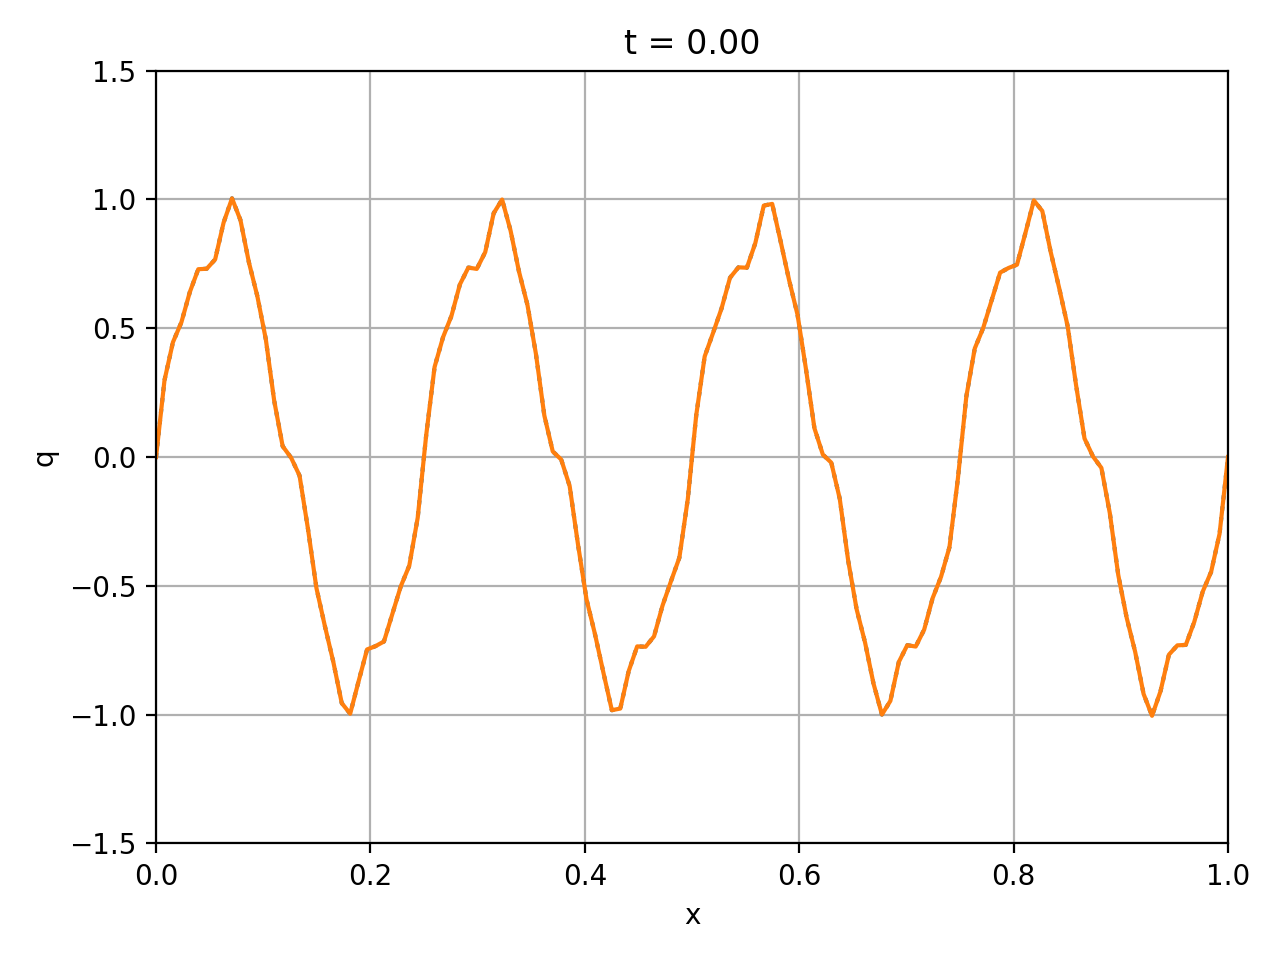

interactive(children=(IntSlider(value=0, description='it', max=99), Output()), _dom_classes=('widget-interact'…

In [8]:
from spitfire import odesolve, SimpleNewtonSolver, ESDIRK64, PIController
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets

x_nodes = np.linspace(0, 1, 128)
q0 = 0.9 * np.sin(8. * np.pi * x_nodes) + 0.1 * np.sin(32. * np.pi * x_nodes) + 0.05 * np.sin(64. * np.pi * x_nodes)
Pe = 1.e4

pde = AdvDiffEqn(x_nodes, Pe)

esdirk64 = ESDIRK64(SimpleNewtonSolver())
controller = PIController(target_error=1.e-8, first_step=1e-4, max_step=5e-2)

output_times = np.linspace(0., 2., 100)

q = odesolve(pde.rhs, q0, output_times,
             linear_setup=pde.setup_superlu,
             linear_solve=pde.solve_superlu,
             step_size=controller,
             method=esdirk64)

%matplotlib notebook
plt.plot(x_nodes, q[0, :], ':')
l1, = plt.plot(x_nodes, q[0, :])
plt.xlim([x_nodes[0], x_nodes[-1]])
plt.ylim([-1.5, 1.5])
plt.grid()
plt.xlabel('x')
plt.ylabel('q')
plt.title(f't = {output_times[0]:.2f}')
plt.tight_layout()

def f(it):
    plt.title(f't = {output_times[it]:.2f}')
    l1.set_ydata(q[it, :])

interact(f, it=widgets.IntSlider(min=0, max=output_times.size-1, step=1, value=0));

## Comparing Linear Solvers

In the next cell we define the `solve` method that will simplify our studies of solver performance later on...

In [3]:
def solve(n_nodes, Pe, solver_choice):
    x_nodes = np.linspace(0., 1., n_nodes)
    pde = AdvDiffEqn(x_nodes, Pe=Pe)
    q0 = 0.9 * np.sin(8. * np.pi * x_nodes) + \
         0.1 * np.sin(32. * np.pi * x_nodes) + \
         0.05 * np.sin(64. * np.pi * x_nodes)
    
    esdirk64 = ESDIRK64(SimpleNewtonSolver())
    controller = PIController(target_error=1.e-8, first_step=1e-5, max_step=5e-2)
    
    methods = dict({
        'FDJ + dense LU': (None,None),
        'dense LU': (pde.setup_lapack_lu, pde.solve_lapack_lu),
        'sparse LU': (pde.setup_superlu, pde.solve_superlu),
        'sparse ILU': (pde.setup_superilu, pde.solve_superilu),
        'Jacobi': (pde.setup_Jacobi, pde.solve_Jacobi),
        'Jacobi-GMRES': (pde.setup_Jacobi_Krylov, pde.solve_GMRES),
        'ILU-GMRES': (pde.setup_ILU_Krylov, pde.solve_GMRES),
        'Jacobi-BiCGStab': (pde.setup_Jacobi_Krylov, pde.solve_BiCGStab),
        'ILU-BiCGStab': (pde.setup_ILU_Krylov, pde.solve_BiCGStab),
    })
    
    setup, solve = methods[solver_choice]
    _, _, _, solve_info = odesolve(pde.rhs, q0,
                                   stop_at_time=0.1,
                                   linear_setup=setup,
                                   linear_solve=solve,
                                   step_size=controller,
                                   method=esdirk64,
                                   return_info=True)
    linear_iter = solve_info['linear iter']
    nonlinear_iter = solve_info['nonlinear iter']
    cput = solve_info['total cpu time (s)']
    nsteps = solve_info['time steps']
    
    return dict({'nsteps': f'{nsteps}',
                 'cput/step (ms)': f'{1.e3 * cput / nsteps:.1f}',
                 'cput/liter (us)': f'{1.e6 * cput / linear_iter:.1f}',
                 'liter/niter': f'{linear_iter / nonlinear_iter:.1f}',
                 'niter/solve': f'{nonlinear_iter / (5 * nsteps):.1f}'})  # 5 implicit stages in ESDIRK64

Now we run the various solvers on a range of grid sizes and print out a giant table of the results. Note that we avoid running the dense LU solvers on the largest grids. Scroll down a bit to see some plots and conclusions drawn from all this data.

In [4]:
Pe = 1.e4

solvers = ['FDJ + dense LU',
           'dense LU',
           'sparse LU',
           'sparse ILU',
           'Jacobi',
           'Jacobi-GMRES',
           'ILU-GMRES',
           'Jacobi-BiCGStab',
           'ILU-BiCGStab']
solvers_wout_dense_LU = list(solvers)
solvers_wout_dense_LU.remove('FDJ + dense LU')
solvers_wout_dense_LU.remove('dense LU')

n_list = [32, 64, 128, 512, 1024, 2048, 4096, 6144, 8192]
n_list_for_dense_LU = list()
for n in n_list:
    if n < 1025:
        n_list_for_dense_LU.append(n)

solver_info = dict()

for n in n_list:
    print(f'number of nodes = {n}')
    print(f'{"solver":<20} {"nsteps":<10} {"cput/step (ms)":<20} {"niter/solve":<20} {"liter/niter":<20} {"cput/liter (us)":<20}')
    print('-' * 112)
    
    for solver in (solvers if n < 1025 else solvers_wout_dense_LU):
        solver_data = solve(n, Pe, solver)
        solver_info[(solver, n)] = solver_data

        print(f'{solver:<20} {solver_data["nsteps"]:<10} {solver_data["cput/step (ms)"]:<20} {solver_data["niter/solve"]:<20} {solver_data["liter/niter"]:<20} {solver_data["cput/liter (us)"]:<20}')
    print('-' * 112)

number of nodes = 32
solver               nsteps     cput/step (ms)       niter/solve          liter/niter          cput/liter (us)     
----------------------------------------------------------------------------------------------------------------
FDJ + dense LU       79         1.0                  1.0                  1.0                  204.8               
dense LU             79         0.8                  1.0                  1.0                  153.8               
sparse LU            79         0.9                  1.0                  1.0                  179.9               
sparse ILU           79         1.2                  1.8                  1.0                  128.6               
Jacobi               79         1.4                  4.6                  1.0                  61.6                
Jacobi-GMRES         79         2.9                  1.8                  10.2                 31.9                
ILU-GMRES            79         3.3                  1

sparse LU            151        3.8                  1.0                  1.0                  757.1               
sparse ILU           151        5.0                  2.0                  1.0                  499.4               
Jacobi               151        5.4                  13.1                 1.0                  81.9                
Jacobi-GMRES         151        7.6                  2.0                  21.1                 35.8                
ILU-GMRES            151        11.3                 2.0                  5.5                  205.0               
Jacobi-BiCGStab      151        6.3                  2.0                  12.2                 51.1                
ILU-BiCGStab         151        7.3                  2.0                  5.5                  132.6               
----------------------------------------------------------------------------------------------------------------
number of nodes = 6144
solver               nsteps     cput/step (ms)      

<IPython.core.display.Javascript object>


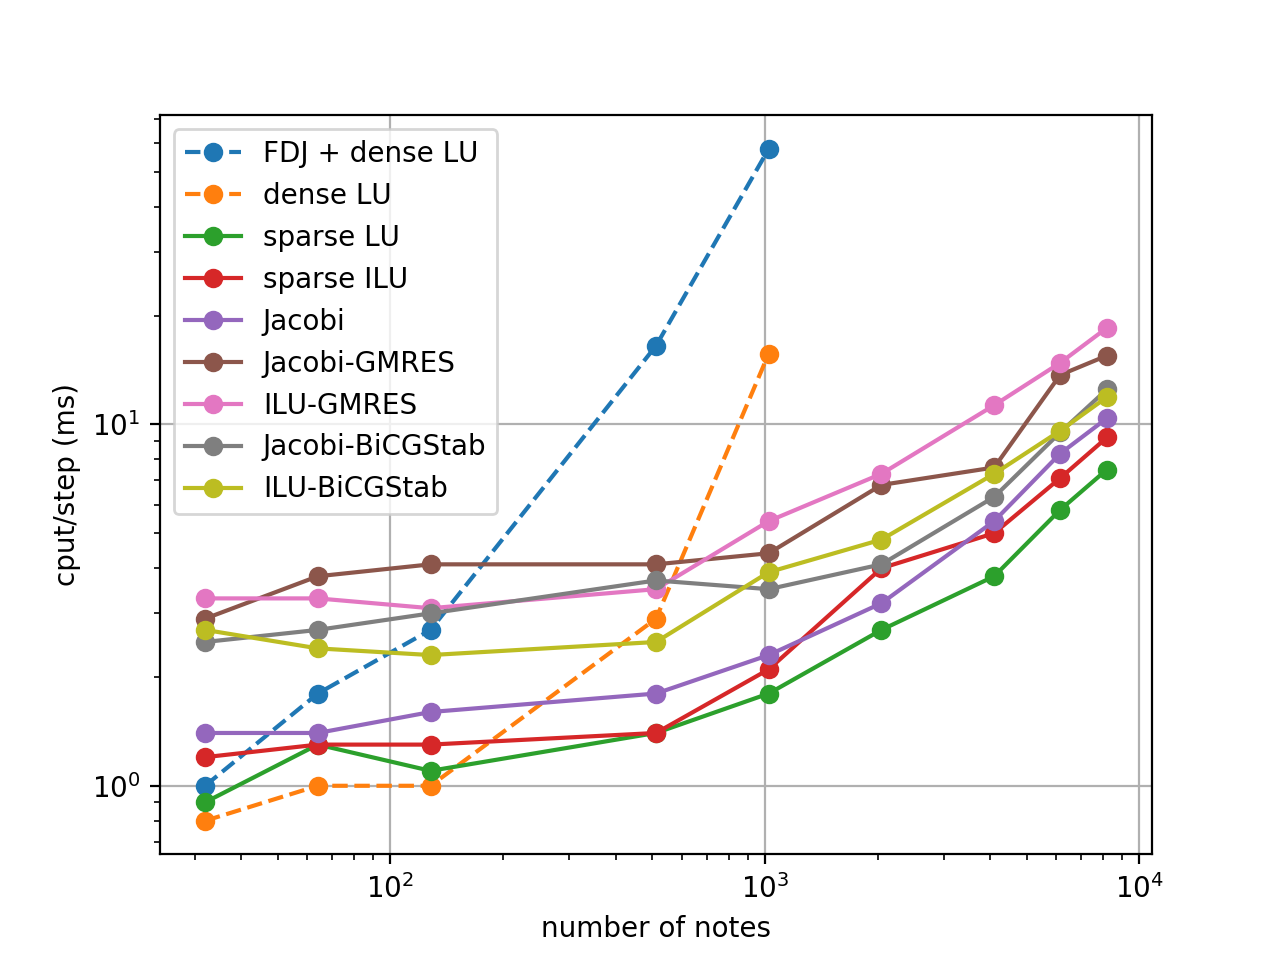

In [7]:
%matplotlib notebook
for s in solvers:
    if s in solvers_wout_dense_LU:
        plt.loglog(n_list, [float(solver_info[(s, n)]['cput/step (ms)']) for n in n_list], 'o-', label=s)
    else:
        plt.loglog(n_list_for_dense_LU, [float(solver_info[(s, n)]['cput/step (ms)']) for n in n_list_for_dense_LU], 'o--', label=s)
plt.legend(loc='best')
plt.grid()
plt.xlabel('number of notes')
plt.ylabel('cput/step (ms)')
plt.show()

<IPython.core.display.Javascript object>


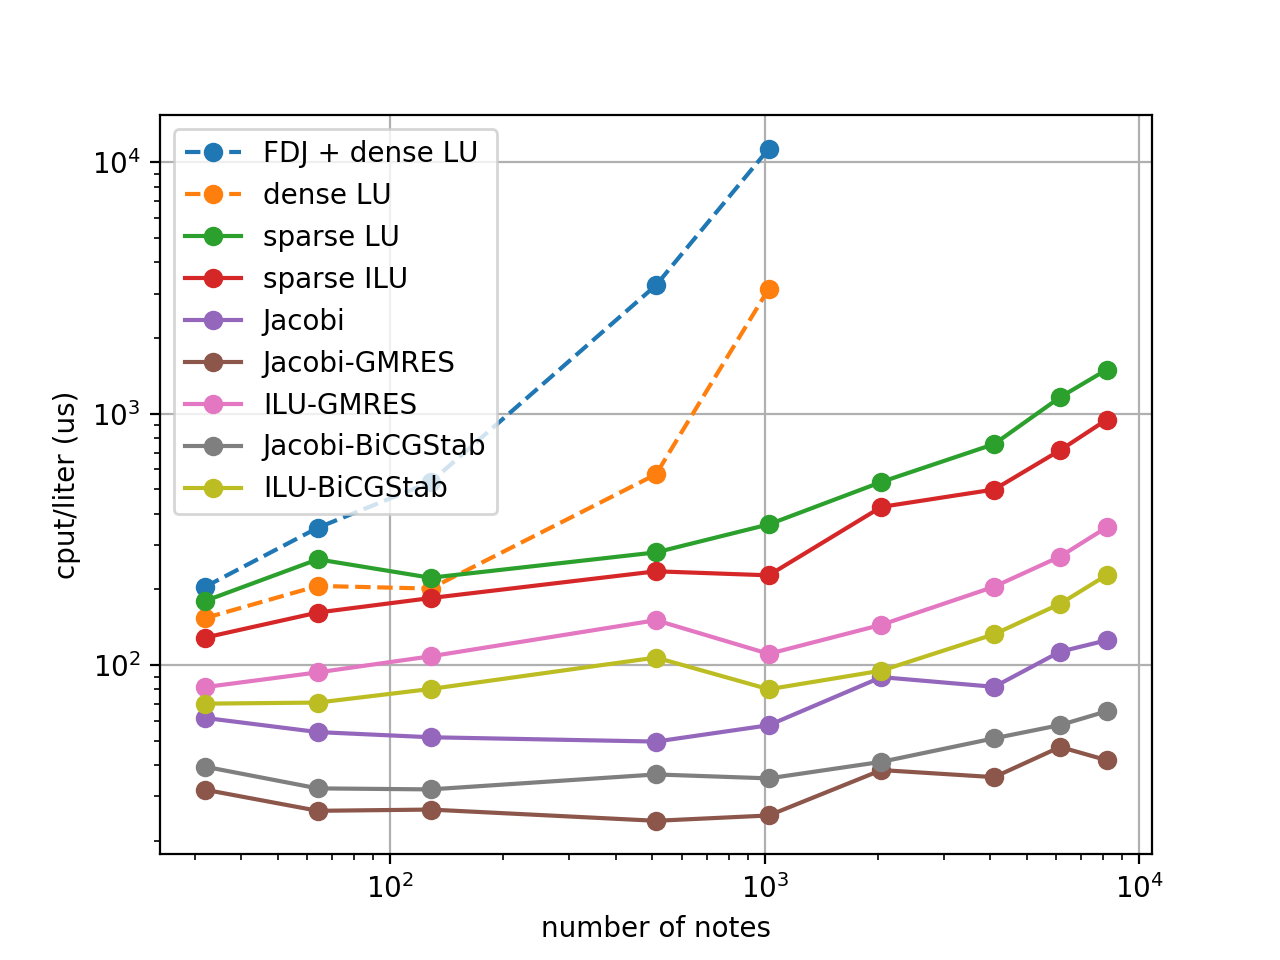

In [6]:
%matplotlib notebook
for s in solvers:
    if s in solvers_wout_dense_LU:
        plt.loglog(n_list, [float(solver_info[(s, n)]['cput/liter (us)']) for n in n_list], 'o-', label=s)
    else:
        plt.loglog(n_list_for_dense_LU, [float(solver_info[(s, n)]['cput/liter (us)']) for n in n_list_for_dense_LU], 'o--', label=s)
plt.legend(loc='best')
plt.grid()
plt.xlabel('number of notes')
plt.ylabel('cput/liter (us)')
plt.show()

## Scalability Results
The first conclusion we can draw from the table and plots above is that the dense LU factorization solvers scale terribly and are practically unusable for all but the smallest grids. They are quite fast on the smallest grids because the overhead incurred by sparse solvers and matrix representations is still relatively large for small matrices.

For the largest systems, an interesting observation is the poor performance of the Jacobi solver (just using the diagonal of the Jacobian matrix), which behaves poorly despite its low cost because it provides such a bad solution to the linear system. This propagates up the solver stack, as the bad linear solutions make the nonlinear solver less efficient (leading to more linear systems) and typically make the adaptive time stepper run with a smaller time step to maintain the same target error (as seen in the table - significantly more steps are needed by Jacobi on large grids). So despite its low cost per linear solution, it doesn't scale particularly well because of its inaccuracy as a solver. Implicit methods can be tricky to design because of the coupling up and down the solver stack - alternatively to this observation, time steppers can be too "aggressive" in taking very large time steps, shifting work to the nonlinear solver and ultimately making linear systems with poorer conditioning than those at smaller time steps (sometimes removing iterative methods from the realm of possibility altogether).

Getting back to the results above, the sparse direct methods and preconditioned Krylov solvers remain quite efficient on large grids. The table shows that the average number of linear iterations per linear system (nonlinear iteration) for the ILU preconditioner is substantially lower than that for the Jacobi preconditioner, as ILU yields a better inexact solution to the linear system. For many problems that can be solved in serial (on a single processor) the performance difference between SuperLU and well-preconditioned iterative methods may never really be too important. A nice benefit of SuperLU is that it is exceptionally robust and can be very efficient given some optimization of the rate of "setup" calls (how often the expensive factorization is called). Iterative solvers can be harder to get "off the ground" because an effective problem-specific preconditioner is needed.

Some final notes are that we've not optimized parameters like the fill factor or drop tolerance for the incomplete LU decomposition, as either a solver or a preconditioner for the Krylov methods. It's possible performance could be improved a bit. Additionally we haven't explored the effect of solver tolerance for the iterative methods - sometimes a solution is not needed to the tolerance of $10^{-12}$ used here, and sometimes the maximum number of iterations can be limited to avoid "over-solving" the problem. Usually there's an interplay between the target error of the adaptive time-stepper, the tolerance of the nonlinear (Newton) solver, and the tolerance of the linear solver - usually you want the linear solver to be more accurate than the nonlinear solver and the nonlinear solver to be be more accurate than the time stepper. This is so that no system is receiving errors from a sub-solver that are larger than it is responsible for itself.

A final note is that performance numbers of Python/NumPy/Cython apps can be very challenging to understand. A careful eye will observe that the Jacobi method has a higher computational time per linear iteration than the Krylov methods, which sounds crazy because the Jacobi iteration is simply a scalar muliplying a NumPy array. Things like this are easier (but still challenging) to explain in lower-level languages without so many layers stack atop one another. Typically if you want to get extreme optimizations (as we do in Spitfire's C++ engine called Griffon) you have to move to C/C++/Fortran and provide Python wrappers (for instance, through Cython).


## Conclusions

This notebook shows how to use a variety of linear solvers for implicit time integration with Spitfire and compares a number of solvers on a canonical partial differential equation.